In [1]:
import numpy.linalg as LA

In [2]:
from torchsummary import summary

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np

from scipy import misc

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
num_classes = 10
batch_size = 32
learning_rate = 0.001

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [9]:
senloader = torch.utils.data.DataLoader(trainset, batch_size=1000,
                                          shuffle=True, num_workers=2)

In [10]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
           )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.fc = nn.Linear(2048, num_classes)
        
    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [11]:
batch=[]
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]
sensitivity=[]

In [12]:
batch.append(64)
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if (epoch+1)==5:
        
        for i,(images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss=criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        print(epoch+1)
        print(running_loss/len(trainset))
        print(running_corrects.double().item()/len(trainset))
        print(test_loss/test_total)
        print(test_correct/test_total)
        train_loss_list.append(running_loss/len(trainset))
        train_acc_list.append(running_corrects.double().item()/len(trainset))
        test_loss_list.append(test_loss/test_total)
        test_acc_list.append(test_correct/test_total)
        

5
0.791984501695633
0.72522
0.8659802205085755
0.7071


In [13]:
grad_list=[]
for i, (images, labels) in enumerate(senloader):
    print(i)
    # 注意模型在GPU中，数据也要搬到GPU中
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_(True)
    # 前向传播
    outputs = model(images)
    _,preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    grad = torch.autograd.grad(loss,images)
    grad_list.append(grad[0].cpu().numpy())
    print(grad[0].shape)

a=grad_list[0] 
for i in range(1,len(grad_list)): 
    a=np.concatenate((a,grad_list[i]),axis=0)

sensitivity.append(LA.norm(a))

0
torch.Size([1000, 3, 32, 32])
1
torch.Size([1000, 3, 32, 32])
2
torch.Size([1000, 3, 32, 32])
3
torch.Size([1000, 3, 32, 32])
4
torch.Size([1000, 3, 32, 32])
5
torch.Size([1000, 3, 32, 32])
6
torch.Size([1000, 3, 32, 32])
7
torch.Size([1000, 3, 32, 32])
8
torch.Size([1000, 3, 32, 32])
9
torch.Size([1000, 3, 32, 32])
10
torch.Size([1000, 3, 32, 32])
11
torch.Size([1000, 3, 32, 32])
12
torch.Size([1000, 3, 32, 32])
13
torch.Size([1000, 3, 32, 32])
14
torch.Size([1000, 3, 32, 32])
15
torch.Size([1000, 3, 32, 32])
16
torch.Size([1000, 3, 32, 32])
17
torch.Size([1000, 3, 32, 32])
18
torch.Size([1000, 3, 32, 32])
19
torch.Size([1000, 3, 32, 32])
20
torch.Size([1000, 3, 32, 32])
21
torch.Size([1000, 3, 32, 32])
22
torch.Size([1000, 3, 32, 32])
23
torch.Size([1000, 3, 32, 32])
24
torch.Size([1000, 3, 32, 32])
25
torch.Size([1000, 3, 32, 32])
26
torch.Size([1000, 3, 32, 32])
27
torch.Size([1000, 3, 32, 32])
28
torch.Size([1000, 3, 32, 32])
29
torch.Size([1000, 3, 32, 32])
30
torch.Size([1000,

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch.append(128)
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if (epoch+1)==5:
        
        for i,(images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss=criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        print(epoch+1)
        print(running_loss/len(trainset))
        print(running_corrects.double().item()/len(trainset))
        print(test_loss/test_total)
        print(test_correct/test_total)
        train_loss_list.append(running_loss/len(trainset))
        train_acc_list.append(running_corrects.double().item()/len(trainset))
        test_loss_list.append(test_loss/test_total)
        test_acc_list.append(test_correct/test_total)

grad_list=[]
for i, (images, labels) in enumerate(senloader):
    print(i)
    # 注意模型在GPU中，数据也要搬到GPU中
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_(True)
    # 前向传播
    outputs = model(images)
    _,preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    grad = torch.autograd.grad(loss,images)
    grad_list.append(grad[0].cpu().numpy())
    print(grad[0].shape)

a=grad_list[0] 
for i in range(1,len(grad_list)): 
    a=np.concatenate((a,grad_list[i]),axis=0)

sensitivity.append(LA.norm(a))

Files already downloaded and verified
5
0.7967194012069703
0.72732
0.9040984790802002
0.6908
0
torch.Size([1000, 3, 32, 32])
1
torch.Size([1000, 3, 32, 32])
2
torch.Size([1000, 3, 32, 32])
3
torch.Size([1000, 3, 32, 32])
4
torch.Size([1000, 3, 32, 32])
5
torch.Size([1000, 3, 32, 32])
6
torch.Size([1000, 3, 32, 32])
7
torch.Size([1000, 3, 32, 32])
8
torch.Size([1000, 3, 32, 32])
9
torch.Size([1000, 3, 32, 32])
10
torch.Size([1000, 3, 32, 32])
11
torch.Size([1000, 3, 32, 32])
12
torch.Size([1000, 3, 32, 32])
13
torch.Size([1000, 3, 32, 32])
14
torch.Size([1000, 3, 32, 32])
15
torch.Size([1000, 3, 32, 32])
16
torch.Size([1000, 3, 32, 32])
17
torch.Size([1000, 3, 32, 32])
18
torch.Size([1000, 3, 32, 32])
19
torch.Size([1000, 3, 32, 32])
20
torch.Size([1000, 3, 32, 32])
21
torch.Size([1000, 3, 32, 32])
22
torch.Size([1000, 3, 32, 32])
23
torch.Size([1000, 3, 32, 32])
24
torch.Size([1000, 3, 32, 32])
25
torch.Size([1000, 3, 32, 32])
26
torch.Size([1000, 3, 32, 32])
27
torch.Size([1000, 3, 32

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch.append(256)
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if (epoch+1)==5:
        
        for i,(images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss=criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        print(epoch+1)
        print(running_loss/len(trainset))
        print(running_corrects.double().item()/len(trainset))
        print(test_loss/test_total)
        print(test_correct/test_total)
        train_loss_list.append(running_loss/len(trainset))
        train_acc_list.append(running_corrects.double().item()/len(trainset))
        test_loss_list.append(test_loss/test_total)
        test_acc_list.append(test_correct/test_total)

grad_list=[]
for i, (images, labels) in enumerate(senloader):
    print(i)
    # 注意模型在GPU中，数据也要搬到GPU中
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_(True)
    # 前向传播
    outputs = model(images)
    _,preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    grad = torch.autograd.grad(loss,images)
    grad_list.append(grad[0].cpu().numpy())
    print(grad[0].shape)

a=grad_list[0] 
for i in range(1,len(grad_list)): 
    a=np.concatenate((a,grad_list[i]),axis=0)

sensitivity.append(LA.norm(a))

Files already downloaded and verified
5
0.8309027672958375
0.71304
0.9059757579803467
0.692
0
torch.Size([1000, 3, 32, 32])
1
torch.Size([1000, 3, 32, 32])
2
torch.Size([1000, 3, 32, 32])
3
torch.Size([1000, 3, 32, 32])
4
torch.Size([1000, 3, 32, 32])
5
torch.Size([1000, 3, 32, 32])
6
torch.Size([1000, 3, 32, 32])
7
torch.Size([1000, 3, 32, 32])
8
torch.Size([1000, 3, 32, 32])
9
torch.Size([1000, 3, 32, 32])
10
torch.Size([1000, 3, 32, 32])
11
torch.Size([1000, 3, 32, 32])
12
torch.Size([1000, 3, 32, 32])
13
torch.Size([1000, 3, 32, 32])
14
torch.Size([1000, 3, 32, 32])
15
torch.Size([1000, 3, 32, 32])
16
torch.Size([1000, 3, 32, 32])
17
torch.Size([1000, 3, 32, 32])
18
torch.Size([1000, 3, 32, 32])
19
torch.Size([1000, 3, 32, 32])
20
torch.Size([1000, 3, 32, 32])
21
torch.Size([1000, 3, 32, 32])
22
torch.Size([1000, 3, 32, 32])
23
torch.Size([1000, 3, 32, 32])
24
torch.Size([1000, 3, 32, 32])
25
torch.Size([1000, 3, 32, 32])
26
torch.Size([1000, 3, 32, 32])
27
torch.Size([1000, 3, 32,

In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch.append(512)
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if (epoch+1)==5:
        
        for i,(images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss=criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        print(epoch+1)
        print(running_loss/len(trainset))
        print(running_corrects.double().item()/len(trainset))
        print(test_loss/test_total)
        print(test_correct/test_total)
        train_loss_list.append(running_loss/len(trainset))
        train_acc_list.append(running_corrects.double().item()/len(trainset))
        test_loss_list.append(test_loss/test_total)
        test_acc_list.append(test_correct/test_total)

grad_list=[]
for i, (images, labels) in enumerate(senloader):
    print(i)
    # 注意模型在GPU中，数据也要搬到GPU中
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_(True)
    # 前向传播
    outputs = model(images)
    _,preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    grad = torch.autograd.grad(loss,images)
    grad_list.append(grad[0].cpu().numpy())
    print(grad[0].shape)

a=grad_list[0] 
for i in range(1,len(grad_list)): 
    a=np.concatenate((a,grad_list[i]),axis=0)

sensitivity.append(LA.norm(a))

Files already downloaded and verified
5
0.8768762901115418
0.69796
0.9415799482345582
0.6697
0
torch.Size([1000, 3, 32, 32])
1
torch.Size([1000, 3, 32, 32])
2
torch.Size([1000, 3, 32, 32])
3
torch.Size([1000, 3, 32, 32])
4
torch.Size([1000, 3, 32, 32])
5
torch.Size([1000, 3, 32, 32])
6
torch.Size([1000, 3, 32, 32])
7
torch.Size([1000, 3, 32, 32])
8
torch.Size([1000, 3, 32, 32])
9
torch.Size([1000, 3, 32, 32])
10
torch.Size([1000, 3, 32, 32])
11
torch.Size([1000, 3, 32, 32])
12
torch.Size([1000, 3, 32, 32])
13
torch.Size([1000, 3, 32, 32])
14
torch.Size([1000, 3, 32, 32])
15
torch.Size([1000, 3, 32, 32])
16
torch.Size([1000, 3, 32, 32])
17
torch.Size([1000, 3, 32, 32])
18
torch.Size([1000, 3, 32, 32])
19
torch.Size([1000, 3, 32, 32])
20
torch.Size([1000, 3, 32, 32])
21
torch.Size([1000, 3, 32, 32])
22
torch.Size([1000, 3, 32, 32])
23
torch.Size([1000, 3, 32, 32])
24
torch.Size([1000, 3, 32, 32])
25
torch.Size([1000, 3, 32, 32])
26
torch.Size([1000, 3, 32, 32])
27
torch.Size([1000, 3, 32

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch.append(1024)
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if (epoch+1)==5:
        
        for i,(images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss=criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        print(epoch+1)
        print(running_loss/len(trainset))
        print(running_corrects.double().item()/len(trainset))
        print(test_loss/test_total)
        print(test_correct/test_total)
        train_loss_list.append(running_loss/len(trainset))
        train_acc_list.append(running_corrects.double().item()/len(trainset))
        test_loss_list.append(test_loss/test_total)
        test_acc_list.append(test_correct/test_total)

grad_list=[]
for i, (images, labels) in enumerate(senloader):
    print(i)
    # 注意模型在GPU中，数据也要搬到GPU中
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_(True)
    # 前向传播
    outputs = model(images)
    _,preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    grad = torch.autograd.grad(loss,images)
    grad_list.append(grad[0].cpu().numpy())
    print(grad[0].shape)

a=grad_list[0] 
for i in range(1,len(grad_list)): 
    a=np.concatenate((a,grad_list[i]),axis=0)

sensitivity.append(LA.norm(a))

Files already downloaded and verified
5
0.9536032823944092
0.66962
0.9811679019927978
0.6579
0
torch.Size([1000, 3, 32, 32])
1
torch.Size([1000, 3, 32, 32])
2
torch.Size([1000, 3, 32, 32])
3
torch.Size([1000, 3, 32, 32])
4
torch.Size([1000, 3, 32, 32])
5
torch.Size([1000, 3, 32, 32])
6
torch.Size([1000, 3, 32, 32])
7
torch.Size([1000, 3, 32, 32])
8
torch.Size([1000, 3, 32, 32])
9
torch.Size([1000, 3, 32, 32])
10
torch.Size([1000, 3, 32, 32])
11
torch.Size([1000, 3, 32, 32])
12
torch.Size([1000, 3, 32, 32])
13
torch.Size([1000, 3, 32, 32])
14
torch.Size([1000, 3, 32, 32])
15
torch.Size([1000, 3, 32, 32])
16
torch.Size([1000, 3, 32, 32])
17
torch.Size([1000, 3, 32, 32])
18
torch.Size([1000, 3, 32, 32])
19
torch.Size([1000, 3, 32, 32])
20
torch.Size([1000, 3, 32, 32])
21
torch.Size([1000, 3, 32, 32])
22
torch.Size([1000, 3, 32, 32])
23
torch.Size([1000, 3, 32, 32])
24
torch.Size([1000, 3, 32, 32])
25
torch.Size([1000, 3, 32, 32])
26
torch.Size([1000, 3, 32, 32])
27
torch.Size([1000, 3, 32

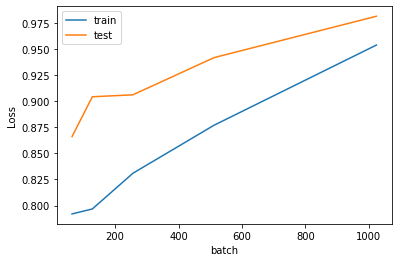

In [35]:
plt.plot(batch, train_loss_list,label="train")
plt.plot(batch, test_loss_list,label="test")
plt.ylabel('Loss')
plt.xlabel('batch')
plt.legend()
plt.show()

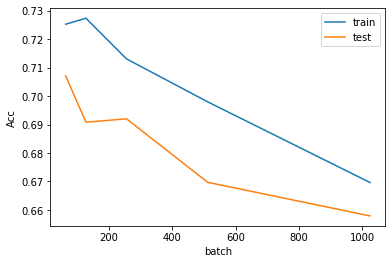

In [38]:
plt.plot(batch, train_acc_list,label="train")
plt.plot(batch, test_acc_list,label="test")
plt.ylabel('Acc')
plt.xlabel('batch')
plt.legend()
plt.show()

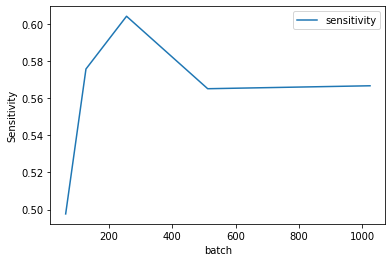

In [39]:
plt.plot(batch, sensitivity,label="sensitivity")
plt.ylabel('Sensitivity')
plt.xlabel('batch')
plt.legend()
plt.show()